In [1]:
import math
import matplotlib as mpl
import matplotlib.pylab as plt
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook
import numpy as np
import palettable

import pic_information
from contour_plots import read_2d_fields
from cori_3d import div0, find_nearest
from json_functions import read_data_from_json

plt.style.use("seaborn-deep")
mpl.rc('text', usetex=True)
mpl.rc('font', **{'family': 'sans-serif'})
mpl.rcParams['text.latex.preamble'] = \
[r"\usepackage{amsmath, bm}",
 r"\DeclareMathAlphabet{\mathsfit}{\encodingdefault}{\sfdefault}{m}{sl}",
 r"\SetMathAlphabet{\mathsfit}{bold}{\encodingdefault}{\sfdefault}{bx}{sl}",
 r"\newcommand{\tensorsym}[1]{\bm{\mathsfit{#1}}}"]
COLORS = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

/usr/projects/particle/xiaocanli/xlipy/xlipy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


# PIC information for both 2D and 3D

In [16]:
pic_run_3d = "3D-Lx150-bg0.2-150ppc-2048KNL"
tframe = 20
tstart = 0
tend = 40
nframes = tend - tstart + 1
picinfo_fname = '../data/pic_info/pic_info_' + pic_run_3d + '.json'
pic_info_3d = read_data_from_json(picinfo_fname)
nx, ny, nz = pic_info_3d.nx, pic_info_3d.ny, pic_info_3d.nz
xdi = pic_info_3d.x_di
zdi = pic_info_3d.z_di
xdi_smooth = xdi[::2]
zdi_smooth = zdi[::2]
xmin, xmax = xdi[0], xdi[-1]
zmin, zmax = zdi[0], zdi[-1]

Reading ../data/pic_info/pic_info_3D-Lx150-bg0.2-150ppc-2048KNL.json


In [17]:
pic_run_2d = "2D-Lx150-bg0.2-150ppc-16KNL"
picinfo_fname = '../data/pic_info/pic_info_' + pic_run_2d + '.json'
pic_info_2d = read_data_from_json(picinfo_fname)
xdi = pic_info_2d.x_di
zdi = pic_info_2d.z_di

Reading ../data/pic_info/pic_info_2D-Lx150-bg0.2-150ppc-16KNL.json


# High-energy particle density

In [18]:
# 2D
tframe = 20
tindex = pic_info_2d.particle_interval * tframe
ne2_high = np.zeros((nz, nx))
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/Cori_runs/' + pic_run_2d + '/'
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne2_high += ne.reshape((nz, nx))
kwargs = {"current_time": tframe,
          "xl": 0, "xr": pic_info_2d.lx_di,
          "zb": -pic_info_2d.lz_di*0.5, "zt": pic_info_2d.lz_di*0.5}
fname = pic_run_dir + "data/Ay.gda"
x, z, Ay = read_2d_fields(pic_info_2d, fname, **kwargs)

Reading data from /net/scratch3/xiaocanli/reconnection/Cori_runs/2D-Lx150-bg0.2-150ppc-16KNL/data/Ay.gda
xrange: (0.000000, 150.000000)
zrange: (-31.250000, 31.250000)


In [19]:
tindex = pic_info_3d.particle_interval * tframe
ne3_high = np.zeros((nz//4, ny//4, nx//4))
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/Cori_runs/' + pic_run_3d + '/'
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne3_high += ne.reshape((nz//4, ny//4, nx//4))

In [20]:
ne3_high *= 40  # Every 40 particles are choosed in the 3D run
ne3_high_xz = np.mean(ne3_high, axis=1)
ne3_high_x = np.sum(np.sum(ne3_high, axis=0), axis=0)

In [21]:
def plot_box(center, width, height, ax, color):
    """Plot a box in figure
    """
    xl = center[0] - width / 2
    xr = center[0] + width / 2
    yb = center[1] - height / 2
    yt = center[1] + height / 2
    xbox = [xl, xr, xr, xl, xl]
    ybox = [yb, yb, yt, yt, yb]
    ax.plot(xbox, ybox, color=color, linewidth=0.5)

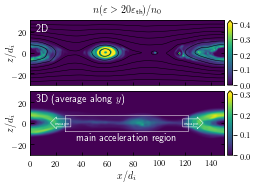

In [40]:
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.1, 0.54, 0.77, 0.36]
ax1 = fig.add_axes(rect1)
p1 = ax1.imshow(ne2_high,
                extent=[xmin, xmax, zmin, zmax],
                vmin=0, vmax=0.4,
                cmap=plt.cm.viridis, aspect='auto',
                origin='lower', interpolation='bicubic')
ax1.contour(x, z, Ay, colors='k', linewidths=0.5)
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_ylabel(r'$z/d_i$', fontsize=10, labelpad=-6)
ax1.text(0.03, 0.95, '2D', color='w', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='left', verticalalignment='top',
         transform=ax1.transAxes)
ax1.set_title(r'$n(\varepsilon>20\varepsilon_\text{th})/n_0$', color='k', fontsize=10)

rect_cbar = np.copy(rect1)
rect_cbar[0] += rect1[2] + 0.015
rect_cbar[2] = 0.02
cbar_ax = fig.add_axes(rect_cbar)
cbar = fig.colorbar(p1, cax=cbar_ax, extend='max')
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4])

rect1[1] -= rect1[3] + 0.03
ax2 = fig.add_axes(rect1)
p2 = ax2.imshow(ne3_high_xz,
                extent=[xmin, xmax, zmin, zmax],
                vmin=0, vmax=0.3,
                cmap=plt.cm.viridis, aspect='auto',
                origin='lower', interpolation='bicubic')
ax2.tick_params(bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='x', which='minor', direction='in')
ax2.tick_params(axis='x', which='major', direction='in')
ax2.tick_params(axis='y', which='minor', direction='in')
ax2.tick_params(axis='y', which='major', direction='in')
ax2.tick_params(labelsize=8)
ax2.set_xlabel(r'$x/d_i$', fontsize=10)
ax2.set_ylabel(r'$z/d_i$', fontsize=10, labelpad=-6)
ax2.text(0.03, 0.95, '3D (average along $y$)',
         color='w', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='left', verticalalignment='top',
         transform=ax2.transAxes)

rect_cbar = np.copy(rect1)
rect_cbar[0] += rect1[2] + 0.015
rect_cbar[2] = 0.02
cbar_ax = fig.add_axes(rect_cbar)
cbar = fig.colorbar(p2, cax=cbar_ax, extend='max')
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([0, 0.1, 0.2, 0.3])

plot_box([75, 0], 95, 15, ax2, 'w')
bbox_props = dict(boxstyle="larrow,pad=0.3", fc="none", ec="w", lw=0.5)
t = ax2.text(25, 0, "escape", ha="center", va="center", rotation=0,
             size=5, bbox=bbox_props, color='w')
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="none", ec="w", lw=0.5)
t = ax2.text(125, 0, "escape", ha="center", va="center", rotation=0,
             size=5, bbox=bbox_props, color='w')
ax2.text(0.5, 0.35, 'main acceleration region',
         color='w', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='center', verticalalignment='top',
         transform=ax2.transAxes)

fig.savefig('../img/img_agu18/ne_high.pdf', dpi=300)

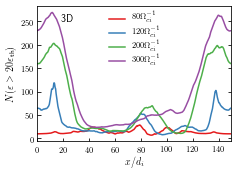

In [86]:
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/Cori_runs/' + pic_run_3d + '/'
fname = pic_run_dir + 'agu18_data/ne_high_x.dat'
fdata = np.fromfile(fname)
sz, = fdata.shape
nbands = 7
ne_high_x = fdata.reshape([-1, nbands, pic_info_3d.nx//4])
ne_tot_x = np.sum(ne_high_x[:, 2:, :], axis=1)
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.15, 0.15, 0.77, 0.75]
ax1 = fig.add_axes(rect1)
ax1.set_prop_cycle('color', COLORS)
xr = np.linspace(0, pic_info_3d.lx_di, pic_info_3d.nx//4)
ixs = [8, 12, 20, 30]
for ix in ixs:
    label1 = r'$' + str(ix * 10) + r'\Omega_{ci}^{-1}$'
    p1, = ax1.plot(xr, ne_tot_x[ix], label=label1)
ax1.legend(loc=9, prop={'size': 8}, ncol=1,
           shadow=False, fancybox=False, frameon=False)
ax1.set_xlim([0, pic_info_3d.lx_di])
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.set_xlabel(r'$x/d_i$', fontsize=10)
ax1.set_ylabel(r'$N(\varepsilon>20\varepsilon_\text{th})$', fontsize=10)
ax1.text(0.12, 0.95, '3D',
         color='k', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='left', verticalalignment='top',
         transform=ax1.transAxes)

fig.savefig('../img/img_agu18/ne_high_x.pdf')

# Power-law index

In [89]:
esc_rate = np.fromfile(pic_run_dir + 'agu18_data/esc_rate.dat')
alpha_mean = np.fromfile(pic_run_dir + 'agu18_data/alpha_mean.dat', dtype=np.float32)
ne_high_acc = np.fromfile(pic_run_dir + 'agu18_data/ne_high_acc.dat')
ne_high_tot = np.fromfile(pic_run_dir + 'agu18_data/ne_high_tot.dat')

Mean value: 4.249151


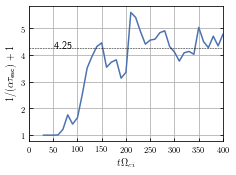

In [118]:
pindex = (esc_rate / alpha_mean) * ne_high_acc / ne_high_tot
pindex += 1.0
twci = np.linspace(10, 400, 40)
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.15, 0.15, 0.77, 0.75]
ax1 = fig.add_axes(rect1)
ax1.plot(twci[2:], pindex[2:])
pmean = np.mean(pindex[10:])
print('Mean value: %f' % pmean)
ax1.plot([0, 400], [pmean, pmean], color='k',
         linestyle='--', linewidth=0.5)
ax1.grid(True)
ax1.set_xlim([0, 400])
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.set_xlabel(r'$t\Omega_{ci}$', fontsize=10)
ax1.set_ylabel(r'$1/(\alpha\tau_\text{esc}) + 1$', fontsize=10)
text1 = ("%0.2f" % pmean)
ax1.text(0.13, 0.75, text1,
         color='k', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='left', verticalalignment='top',
         transform=ax1.transAxes)

fig.savefig('../img/img_agu18/pindex.pdf')

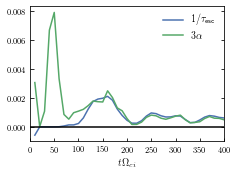

In [127]:
esc_rate[1] = 0
alpha_real = 3.0 * alpha_mean * ne_high_tot / ne_high_acc
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.15, 0.15, 0.77, 0.75]
ax1 = fig.add_axes(rect1)
p1, = ax1.plot(twci, esc_rate, label=r'$1/\tau_\text{esc}$')
# p2, = plt.plot(alpha_mean)
p3, = ax1.plot(twci, alpha_real, label=r'$3\alpha$')
p4, = ax1.plot([0, 400], [0, 0], color='k')
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.set_xlim([0, 400])
ax1.set_xlabel(r'$t\Omega_{ci}$', fontsize=10)
# ax1.set_ylabel(r'$1/(\alpha\tau_\text{esc}) + 1$', fontsize=10)
ax1.legend(loc=1, prop={'size': 10}, ncol=1,
           shadow=False, fancybox=False, frameon=False)

fig.savefig('../img/img_agu18/rates.pdf')